# Importing and Setup

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

# Step 1: Load the CSV files into DataFrames
employees = pd.read_csv('audio_visual_employees_updated.csv')
inventory = pd.read_csv('audio_visual_production_inventory_updated.csv')
sales = pd.read_csv('audio_visual_sales_updated.csv')
stores = pd.read_csv('audio_visual_stores_updated.csv')

# Clean and prepare data

In [5]:
# Convert date columns to datetime for time-based analysis
sales['Date'] = pd.to_datetime(sales['Date'])
inventory['Date'] = pd.to_datetime(inventory['Date'])

# Feature engineering: Add useful calculated columns
employees['Total_Leave_Days'] = employees['Annual_Leave_Days'] + employees['Sick_Leave_Days']
inventory['Waste_Percentage'] = (inventory['Waste_Cost_INR'] / inventory['Actual_Cost_INR']) * 100
sales['Revenue_per_Unit'] = sales['Revenue_INR'] / sales['Units_Sold']

# Merge datasets for combined insights
# Employees + Stores on Store_ID
emp_stores = pd.merge(employees, stores, on='Store_ID', how='left')
# Sales + Stores on City (proxy join, as sales lacks Store_ID; may have duplicates if cities have multiple stores)
sales_stores = pd.merge(sales, stores, on='City', how='left')

# Sneak peek of each dataset
print("Employees Preview:\n", employees.head())
print("\nInventory Preview:\n", inventory.head())
print("\nSales Preview:\n", sales.head())
print("\nStores Preview:\n", stores.head())


Employees Preview:
    Employee_ID  Job_Title  Annual_Leave_Days  Sick_Leave_Days  Bonus_INR  \
0            1    Manager                 14                6      52098   
1            2  Sales Rep                 25                3     108696   
2            3    Analyst                 15                8      24165   
3            4    Manager                 17                5      86237   
4            5    Manager                 22                5     113850   

   Store_ID  Total_Leave_Days  
0         4                20  
1        12                28  
2         1                23  
3        10                22  
4        11                27  

Inventory Preview:
    Prod_ID       Date Product_Category Component  Actual_Cost_INR  \
0        1 2025-02-26      Accessories    Mounts           994141   
1        2 2023-12-10       Projectors    Lenses           723939   
2        3 2025-05-15      Accessories    Cables           723398   
3        4 2024-06-24             

# Step 3: Generate insights

In [6]:
print("\n=== Employee Insights ===")
top_bonuses = employees[['Employee_ID', 'Job_Title', 'Bonus_INR']].sort_values(by='Bonus_INR', ascending=False).head(5)
print("Top 5 Employees by Bonus:\n", top_bonuses)
avg_leave_by_role = employees.groupby('Job_Title')['Total_Leave_Days'].mean().sort_values(ascending=False)
print("\nAverage Total Leave Days by Job Title:\n", avg_leave_by_role)
emp_count_bonus = emp_stores.groupby('Store_ID').agg({'Employee_ID': 'count', 'Bonus_INR': 'mean'}).rename(columns={'Employee_ID': 'Num_Employees'})
print("\nEmployee Count and Average Bonus by Store:\n", emp_count_bonus)

print("\n=== Inventory Insights ===")
avg_waste_by_cat = inventory.groupby('Product_Category')['Waste_Percentage'].mean().sort_values(ascending=False)
print("Average Waste Percentage by Product Category:\n", avg_waste_by_cat)
waste_reasons = inventory['Waste_Reason'].value_counts()
print("\nWaste Reason Counts:\n", waste_reasons)
prod_inventory = inventory.groupby('Product_Category').agg({'Units_Produced': 'sum', 'Inventory_Level': 'mean'})
print("\nTotal Units Produced and Average Inventory Level by Category:\n", prod_inventory)

print("\n=== Sales Insights ===")
top_products = sales.groupby('Product_Category')['Revenue_INR'].sum().sort_values(ascending=False).head(5)
print("Top 5 Product Categories by Total Revenue:\n", top_products)
avg_rev_per_unit_city = sales.groupby('City')['Revenue_per_Unit'].mean().sort_values(ascending=False)
print("\nAverage Revenue per Unit by City:\n", avg_rev_per_unit_city)
corr_sales = sales[['Units_Sold', 'Revenue_INR']].corr().iloc[0, 1]
print(f"\nCorrelation between Units Sold and Revenue: {corr_sales:.2f}")

print("\n=== Store Insights ===")
avg_store_rev_city = stores.groupby('City')['Revenue_INR'].mean().sort_values(ascending=False)
print("Average Store Revenue by City:\n", avg_store_rev_city)
corr_store = stores[['Size_SqFt', 'Revenue_INR']].corr().iloc[0, 1]
print(f"\nCorrelation between Store Size (SqFt) and Revenue: {corr_store:.2f}")
top_stores_employees = stores.sort_values(by='Num_Employees', ascending=False).head(5)[['Store_ID', 'City', 'Num_Employees']]
print("\nTop 5 Stores by Number of Employees:\n", top_stores_employees)


=== Employee Insights ===
Top 5 Employees by Bonus:
     Employee_ID  Job_Title  Bonus_INR
10           11   Engineer     147548
42           43    Analyst     141754
36           37  Sales Rep     140388
19           20    Analyst     130474
34           35    Manager     130319

Average Total Leave Days by Job Title:
 Job_Title
Sales Rep     27.714286
Analyst       26.000000
Engineer      26.000000
Technician    24.333333
Manager       23.461538
Name: Total_Leave_Days, dtype: float64

Employee Count and Average Bonus by Store:
           Num_Employees      Bonus_INR
Store_ID                              
1                     4   88664.250000
2                     5   66776.400000
3                     1  102240.000000
4                     5   66331.200000
5                     6   70812.666667
6                     3   68956.333333
7                     2   90969.000000
8                     1  115932.000000
9                     4   74382.000000
10                    2   82557.50

# Step 4: Generate visualizations

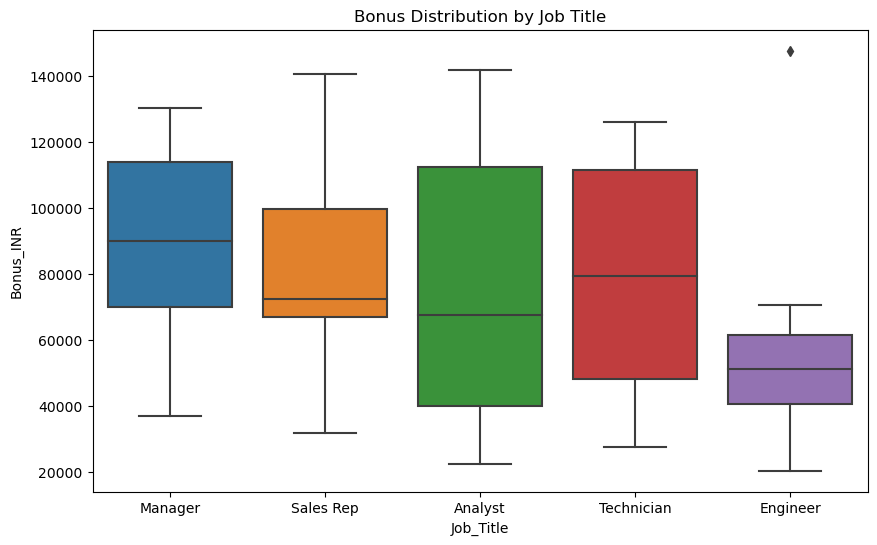

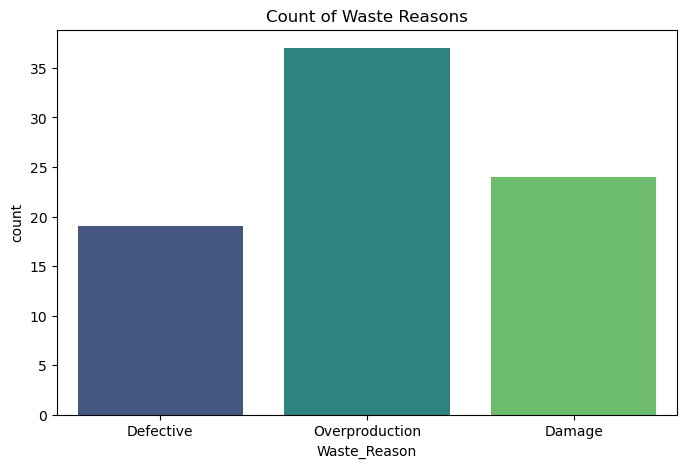

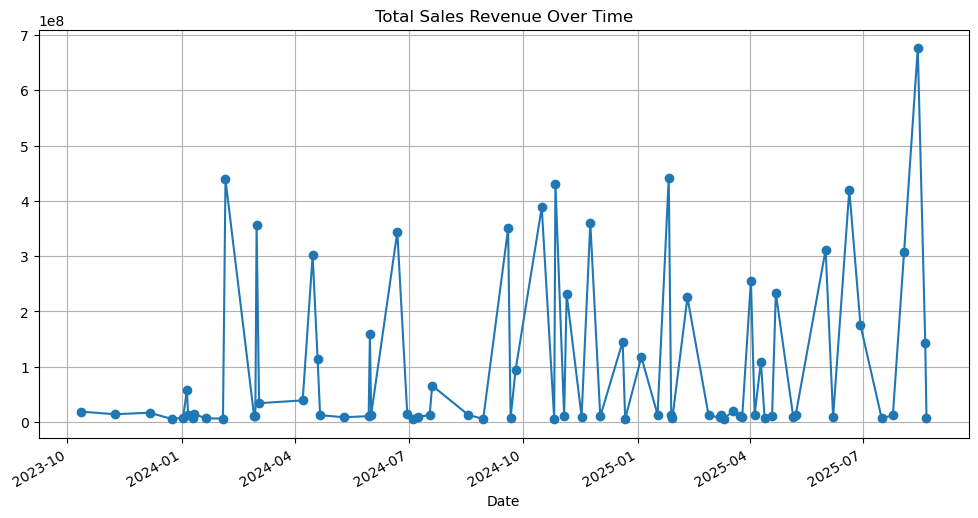

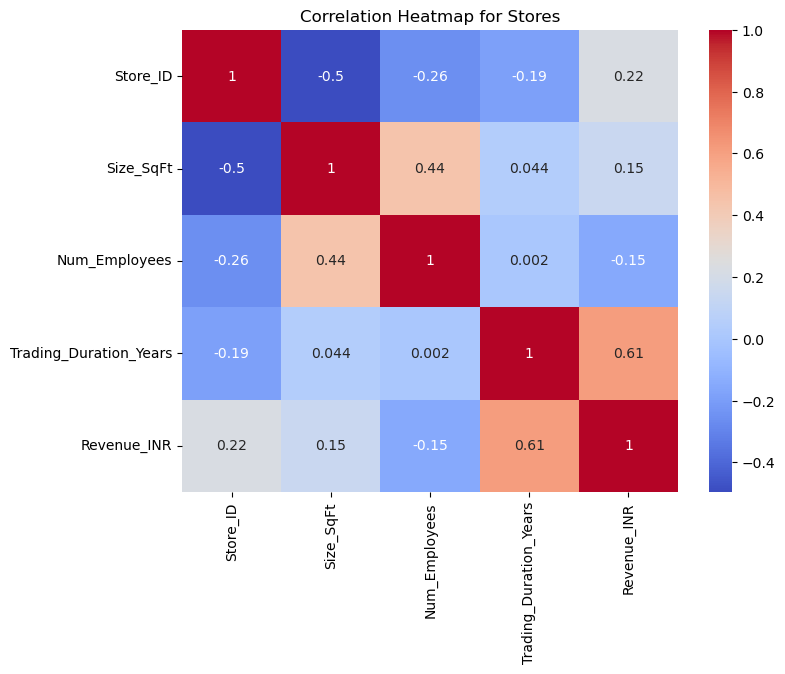

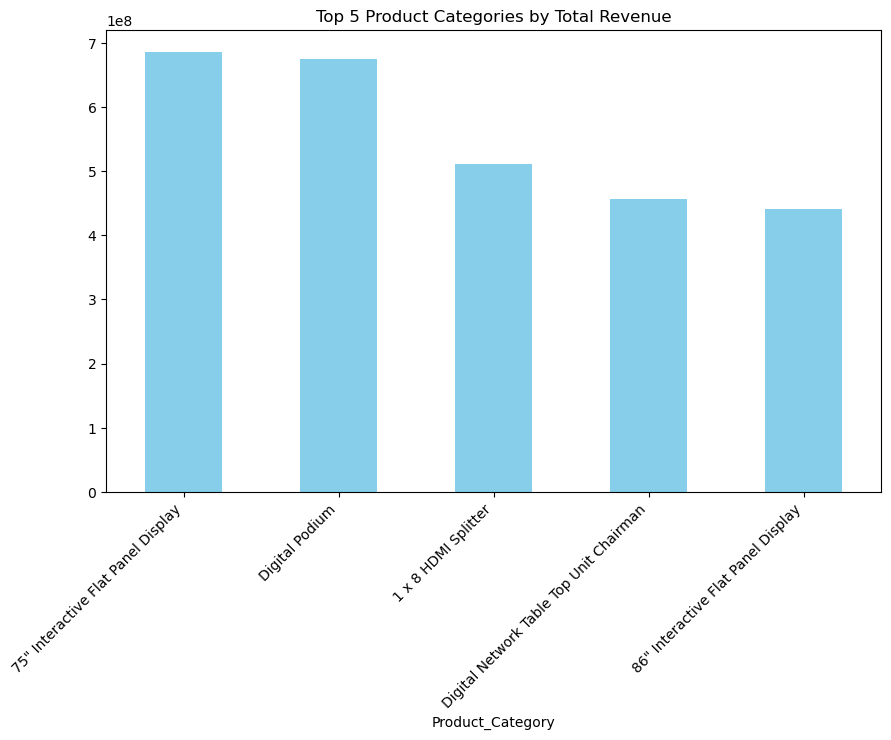

In [7]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Job_Title', y='Bonus_INR', data=employees)
plt.title('Bonus Distribution by Job Title')
plt.show()

plt.figure(figsize=(8, 5))
sns.countplot(x='Waste_Reason', data=inventory, palette='viridis')
plt.title('Count of Waste Reasons')
plt.show()

revenue_time = sales.groupby('Date')['Revenue_INR'].sum()
plt.figure(figsize=(12, 6))
revenue_time.plot(kind='line', marker='o')
plt.title('Total Sales Revenue Over Time')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(stores.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap for Stores')
plt.show()

top_products.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Top 5 Product Categories by Total Revenue')
plt.xticks(rotation=45, ha='right')
plt.show()


# Export for Power BI

In [8]:
emp_stores.to_csv('merged_employees_stores.csv', index=False)
sales_stores.to_csv('merged_sales_stores.csv', index=False)
print("\nMerged CSVs exported.")


Merged CSVs exported.


# Preparing to shift to sql and Power BI

In [9]:

# Reload datasets (if needed; assumes from previous steps)
employees = pd.read_csv('audio_visual_employees_updated.csv')
inventory = pd.read_csv('audio_visual_production_inventory_updated.csv')
sales = pd.read_csv('audio_visual_sales_updated.csv')
stores = pd.read_csv('audio_visual_stores_updated.csv')

# Convert date columns to datetime
sales['Date'] = pd.to_datetime(sales['Date'])
inventory['Date'] = pd.to_datetime(inventory['Date'])

# Feature engineering: Create new columns
employees['Total_Leave_Days'] = employees['Annual_Leave_Days'] + employees['Sick_Leave_Days']
inventory['Waste_Percentage'] = (inventory['Waste_Cost_INR'] / inventory['Actual_Cost_INR']) * 100
sales['Revenue_per_Unit'] = sales['Revenue_INR'] / sales['Units_Sold']

# Merge datasets
emp_stores = pd.merge(employees, stores, on='Store_ID', how='left')  # Employees + Stores
sales_stores = pd.merge(sales, stores, on='City', how='left')  # Sales + Stores (proxy on City)

# Quick check: Preview merged data
print("Merged Employees-Stores Preview:\n", emp_stores.head())
print("\nMerged Sales-Stores Preview:\n", sales_stores.head())

# Export cleaned/merged CSVs for SQL or Power BI
emp_stores.to_csv('cleaned_emp_stores.csv', index=False)
sales_stores.to_csv('cleaned_sales_stores.csv', index=False)
print("\nCleaned and merged CSVs exported.")


Merged Employees-Stores Preview:
    Employee_ID  Job_Title  Annual_Leave_Days  Sick_Leave_Days  Bonus_INR  \
0            1    Manager                 14                6      52098   
1            2  Sales Rep                 25                3     108696   
2            3    Analyst                 15                8      24165   
3            4    Manager                 17                5      86237   
4            5    Manager                 22                5     113850   

   Store_ID  Total_Leave_Days Country          State       City  Size_SqFt  \
0         4                20   India        Haryana  Faridabad      10651   
1        12                28   India  Uttar Pradesh      Noida      10454   
2         1                23   India          Delhi      Delhi      14851   
3        10                22   India        Haryana  Faridabad      10956   
4        11                27   India        Haryana   Gurugram       5697   

   Num_Employees  Trading_Duration_Years

# Query and Analyze with SQL

In [11]:

# Reload cleaned/merged DataFrames (from Step 3 exports, or recreate if needed)
emp_stores = pd.read_csv('cleaned_emp_stores.csv')
sales_stores = pd.read_csv('cleaned_sales_stores.csv')
inventory = pd.read_csv('audio_visual_production_inventory_updated.csv')  # Reload original if needed

# Set up SQLite database
conn = sqlite3.connect(':memory:')  # In-memory DB
emp_stores.to_sql('emp_stores', conn, index=False, if_exists='replace')
sales_stores.to_sql('sales_stores', conn, index=False, if_exists='replace')
inventory.to_sql('inventory', conn, index=False, if_exists='replace')

# Example Query 1: Average bonus by job title from emp_stores
query1 = """
SELECT Job_Title, AVG(Bonus_INR) AS Avg_Bonus
FROM emp_stores
GROUP BY Job_Title
ORDER BY Avg_Bonus DESC;
"""
result1 = pd.read_sql_query(query1, conn)
print("Average Bonus by Job Title:\n", result1)

# Example Query 2: Total revenue by city from sales_stores (handling duplicates with aggregation)
query2 = """
SELECT City, SUM(Revenue_INR_x) / COUNT(DISTINCT Store_ID) AS Adjusted_Total_Revenue
FROM sales_stores
GROUP BY City
ORDER BY Adjusted_Total_Revenue DESC;
"""
result2 = pd.read_sql_query(query2, conn)
print("\nAdjusted Total Revenue by City:\n", result2)

# Example Query 3: High-waste products from inventory
query3 = """
SELECT Product_Category, AVG(Waste_Percentage) AS Avg_Waste_Pct
FROM (SELECT *, (Waste_Cost_INR * 1.0 / Actual_Cost_INR) * 100 AS Waste_Percentage FROM inventory)
GROUP BY Product_Category
HAVING Avg_Waste_Pct > 10
ORDER BY Avg_Waste_Pct DESC;
"""
result3 = pd.read_sql_query(query3, conn)
print("\nProduct Categories with High Waste (>10%):\n", result3)

# Close connection
conn.close()

# Export query results as CSV for Power BI
result1.to_csv('sql_insight_bonuses.csv', index=False)
result2.to_csv('sql_insight_revenue.csv', index=False)
result3.to_csv('sql_insight_waste.csv', index=False)
print("\nSQL results exported as CSVs.")


Average Bonus by Job Title:
     Job_Title     Avg_Bonus
0     Manager  90384.692308
1   Sales Rep  82569.571429
2  Technician  78743.777778
3     Analyst  74319.538462
4    Engineer  59908.875000

Adjusted Total Revenue by City:
         City  Adjusted_Total_Revenue
0   Gurugram              4097660978
1      Delhi              3244980546
2      Noida               186805552
3  Ghaziabad               166730310
4  Faridabad               120270737

Product Categories with High Waste (>10%):
   Product_Category  Avg_Waste_Pct
0       Projectors      11.520286
1         Speakers      10.772794

SQL results exported as CSVs.
